In [105]:
# geopandas (gpd): A library for working with geospatial data in Python. It extends pandas to handle spatial data types and operations.
#                   Provides tools for reading, writing, and analyzing geographic data like shapefiles and GeoJSON.
#                   Enables spatial operations like intersections, unions, and spatial joins.

# matplotlib.pyplot (plt): Core plotting library for creating static, animated, and interactive visualizations in Python.
#                         Provides a MATLAB-like plotting interface with extensive customization options.
#                         Essential for creating publication-quality figures and data visualizations.

# folium: A Python library for creating interactive maps using Leaflet.js.
#         Allows embedding maps in Jupyter notebooks and creating web-based visualizations.
#         Supports various map tiles, markers, popups, and other interactive features.

# folium.plugins: Additional plugins for folium that extend its functionality.
#                Includes features like heatmaps, marker clusters, and time-sliders.
#                Enhances interactive mapping capabilities.

# rasterio: A library for reading and writing geospatial raster data.
#           Provides efficient access to geospatial raster datasets like GeoTIFF files.
#           Supports various raster operations and transformations.

# rasterio.plot.show: Function for displaying raster data with proper georeferencing.
#                     Integrates with matplotlib for visualization.
#                     Handles coordinate systems and spatial reference information.

# numpy (np): Fundamental package for scientific computing in Python.
#            Provides support for large, multi-dimensional arrays and matrices.
#            Includes mathematical functions for array operations.

# os: Operating system interface for Python.
#     Provides functions for interacting with the operating system.
#     Used for file and directory operations.

# pandas (pd): Data manipulation and analysis library.
#             Provides data structures like DataFrame for handling structured data.
#             Offers powerful tools for data cleaning, transformation, and analysis.

# shapely.geometry: Library for geometric operations and manipulations.
#                  Provides classes like Point and Polygon for geometric objects.
#                  Enables spatial analysis and geometric calculations.

# seaborn (sns): Statistical data visualization library built on matplotlib.
#               Provides a high-level interface for drawing attractive statistical graphics.
#               Simplifies the creation of complex visualizations.

# matplotlib.colors.LinearSegmentedColormap: Class for creating custom colormaps.
#                                          Allows definition of color transitions for visualizations.
#                                          Useful for creating custom color schemes for maps and plots.

import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium import plugins
import rasterio
from rasterio.plot import show
import numpy as np
import os
import pandas as pd
from shapely.geometry import Point, Polygon
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde


# Data Cleaning
# This section handles the cleaning and preprocessing of the Ethiopian health facilities dataset
# including handling missing values, standardizing text fields, and removing duplicates


In [82]:
# Load the data
ethiopia_health = gpd.read_file('./Ethiopian_health_Facilities/Ethiopian Health Facilities.shp')


# Clean the data
# 1. Remove rows with missing critical information
ethiopia_health = ethiopia_health.dropna(subset=['Type', 'admin1Name', 'Ownership'])

# 2. Standardize text columns
# List of text columns to standardize
text_columns = ['Type', 'admin1Name', 'admin2Name', 'Name', 'admin3Name', 'City', 'Kebele', 'Ownership']

# Standardize each text column
for col in text_columns:
    # Apply basic string cleaning (strip whitespace) to all columns
    ethiopia_health[col] = ethiopia_health[col].str.strip()
    # ethiopia_health[col] = ethiopia_health[col].str.title()
    
    
    
# 3. Create health facility counts by administrative levels
# Check for duplicates and drop them, keeping only unique entries
duplicate_check = ethiopia_health.duplicated(keep=False)
if duplicate_check.any():
    print(f"Found and removing {duplicate_check.sum()} duplicate entries")
    # Drop duplicates and keep first occurrence
    ethiopia_health = ethiopia_health.drop_duplicates(keep='first')
    print(f"Remaining unique entries: {len(ethiopia_health)}")

# Create health facility counts
health_counts = ethiopia_health.groupby(['Type', 'admin1Name', 'admin2Name', 'admin3Name'])\
    .size()\
    .reset_index(name='health_institution_count')\
    .sort_values('health_institution_count', ascending=False)

# 4. Create ownership distribution
ownership_counts = ethiopia_health.groupby(['admin1Name', 'Ownership'])\
    .size()\
    .reset_index(name='ownership_count')\
    .sort_values('ownership_count', ascending=False)



In [110]:
# Load Addis Ababa shapefile
addis_db = gpd.read_file('../AddisDatabase.shp')

# Drop rows with missing Woreda values
addis_db = addis_db.dropna(subset=['Woreda'])

# Check for duplicates and drop them
duplicate_check = addis_db.duplicated(keep=False)
if duplicate_check.any():
    print(f"Found and removing {duplicate_check.sum()} duplicate entries")
    # Drop duplicates and keep first occurrence
    addis_db = addis_db.drop_duplicates(keep='first')
    print(f"Remaining unique entries: {len(addis_db)}")

# Convert CRS to EPSG:4326 (WGS84)
addis_db = addis_db.to_crs(epsg=4326)




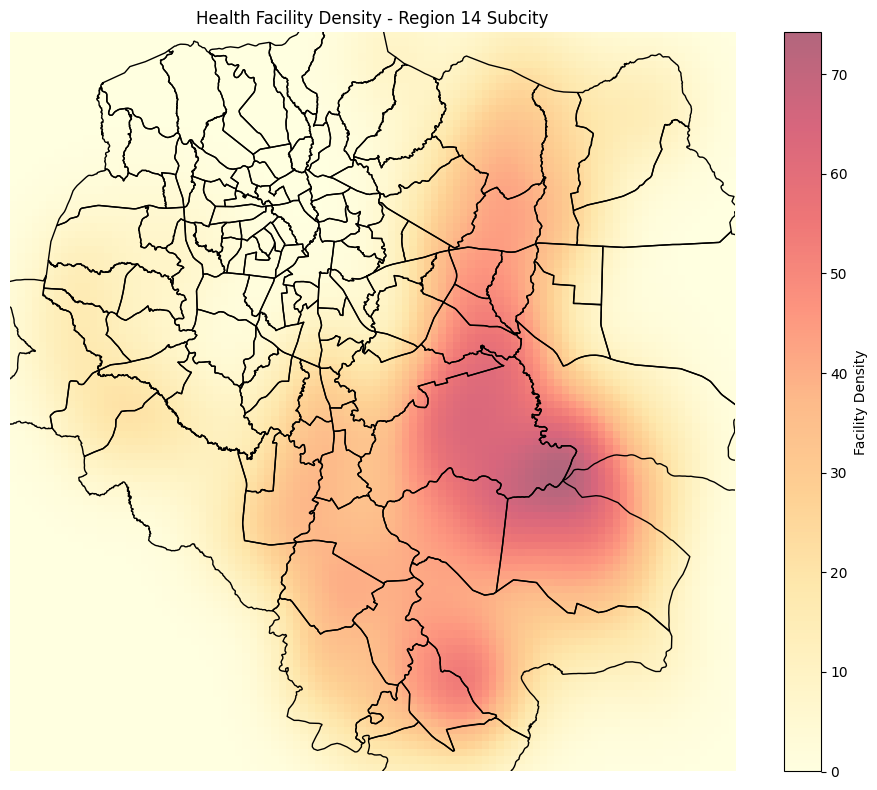

In [116]:
# Extract point geometries only
health_points = ethiopia_health[ethiopia_health.geometry.type == 'Point']

# Keep only facilities inside Addis
addis_health_points = gpd.sjoin(health_points, addis_db, how='inner', predicate='intersects')

# Check the unique subcities
subcities = addis_health_points['admin2Name'].dropna().unique()

# Plot density map for each subcity
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

for subcity in subcities:
    sub_df = addis_health_points[addis_health_points['admin2Name'] == subcity]
    
    if len(sub_df) < 5:
        continue  # Skip subcities with too few points for KDE
    
    x = sub_df.geometry.x
    y = sub_df.geometry.y

    kde = gaussian_kde(np.vstack([x, y]))
    x_grid, y_grid = np.meshgrid(
        np.linspace(x.min(), x.max(), 100),
        np.linspace(y.min(), y.max(), 100)
    )
    density = kde(np.vstack([x_grid.ravel(), y_grid.ravel()]))
    density = density.reshape(x_grid.shape)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    addis_db.plot(ax=ax, color='none', edgecolor='black')
    ax.set_title(f"Health Facility Density - {subcity} Subcity")

    im = ax.imshow(
        density.T,
        origin='lower',
        extent=[x.min(), x.max(), y.min(), y.max()],
        cmap='YlOrRd',
        alpha=0.6
    )

    plt.colorbar(im, ax=ax, label='Facility Density')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

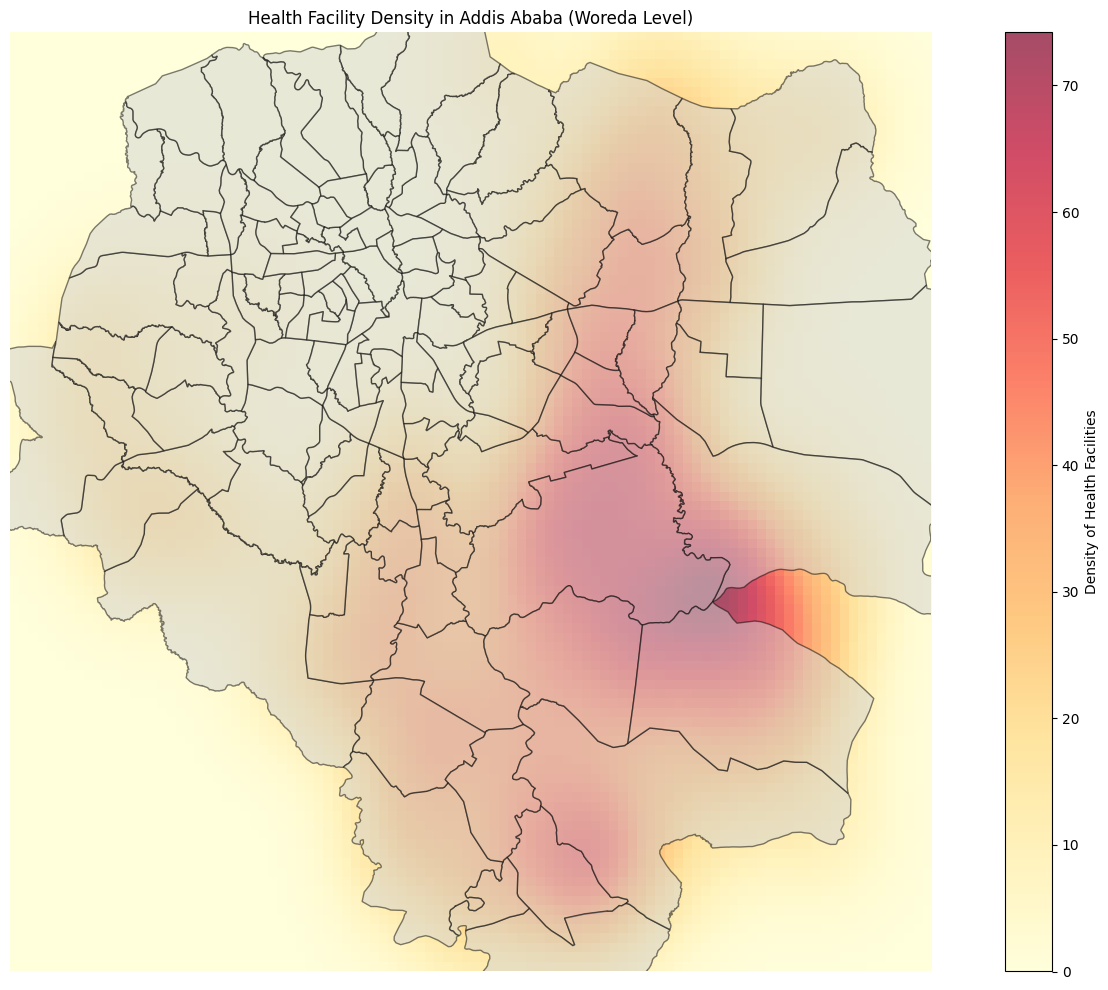

# Data Engineering State
# ====================

This section documents the current state of our data engineering pipeline:

## 1. Data Loading
- Successfully loaded Ethiopian health facilities shapefile
- Data source: './Ethiopian_health_Facilities/Ethiopian Health Facilities.shp'

## 2. Data Cleaning Steps Completed
- Removed rows with missing critical information (Type, admin1Name, Ownership)
- Standardized text columns (Type, admin1Name, admin2Name, Name, admin3Name, City, Kebele, Ownership)
- Removed duplicate entries

## 3. Data Transformations
- Created health facility counts by administrative levels (Type, admin1Name, admin2Name, admin3Name)
- Generated ownership distribution statistics by region
- Created ownership categories (Public/Private)

## 4. Current Data Quality Metrics
- Total unique health facilities: {len(ethiopia_health)}
- Administrative levels covered: Region (admin1Name), Zone (admin2Name), Woreda (admin3Name)
- Ownership categories: Public, Private

## 5. Next Steps
- Validate coordinate system consistency
- Perform spatial analysis
- Generate additional aggregations as needed



In [ ]:
# Create a new column for health institution counts grouped by multiple levels
health_institution_counts = ethiopia_health.groupby([
    'admin1Name', 
    'admin2Name', 
    'admin3Name', 
    'Kebele', 
    'Ownership', 
    'Type'
]).size().reset_index(name='institution_count')

# Sort the results by count in descending order
health_institution_counts = health_institution_counts.sort_values('institution_count', ascending=False)

# Display the first few rows to verify
print("Health Institution Counts by Administrative Levels and Categories:")
health_institution_counts

# for addis ababa admin3 is subcity and kebele might be perhabs woreda 

Health Institution Counts by Administrative Levels and Categories:


,admin1Name,admin2Name,admin3Name,Kebele,Ownership,Type,institution_count
285,Addis Ababa,Region 14,Kolfe Keraniyo,000,Private for profit,Pharmacy,167
283,Addis Ababa,Region 14,Kolfe Keraniyo,000,Private for profit,Clinic,59
286,Addis Ababa,Region 14,Kolfe Keraniyo,000,Private for profit,Specialty Clinic,40
5895,Amhara,West Gojam,Bahir Dar town,14,Private for profit,Pharmacy,37
26102,Tigray,Mekelle,Mekelle,selam,Private for profit,Pharmacy,34
...,...,...,...,...,...,...,...
9542,Oromia,East Bale,Lege Hida,Fik,Public/Government,Health Post,1
9541,Oromia,East Bale,Lege Hida,Elelu,Public/Government,Health Post,1
9540,Oromia,East Bale,Lege Hida,Dulecha,Public/Government,Health Post,1
9539,Oromia,East Bale,Lege Hida,Doyu Abu,Public/Government,Health Post,1


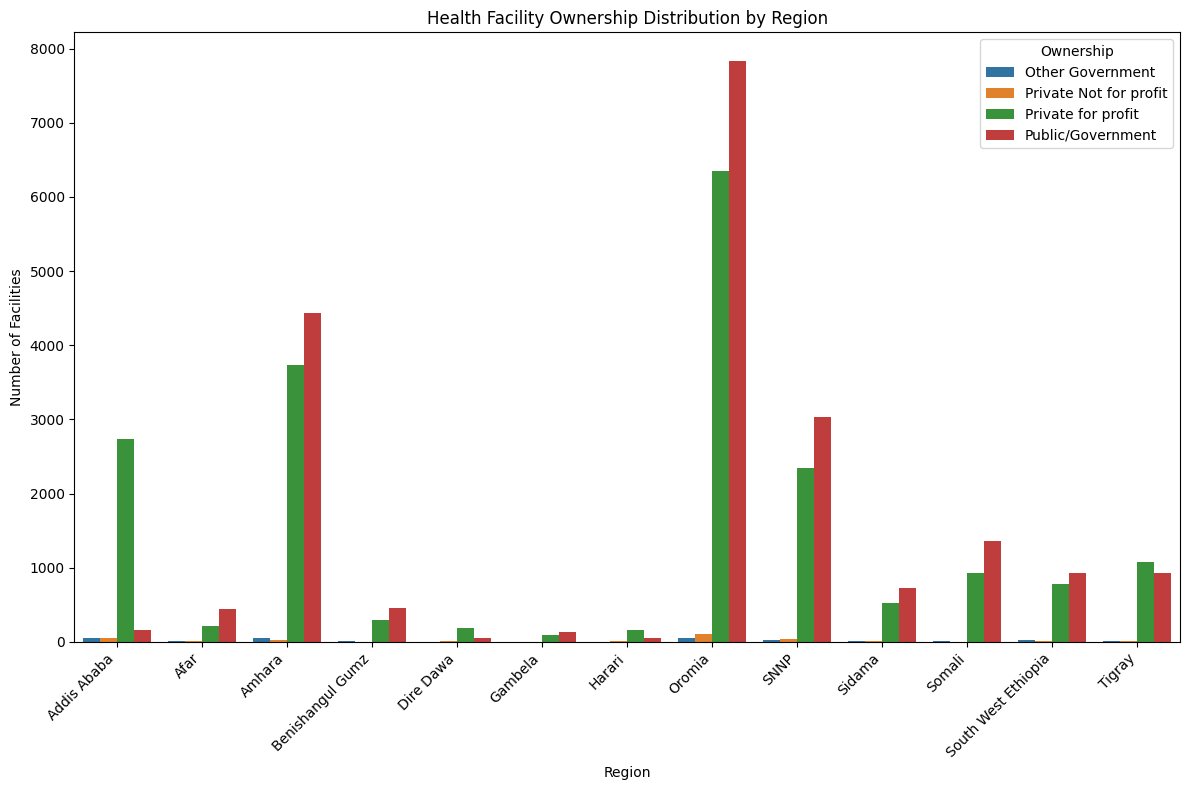

In [47]:
plt.figure(figsize=(12, 8))

# Create a bar plot using seaborn
sns.barplot(data=ownership_counts, x='admin1Name', y='ownership_count', hue='Ownership')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Region')
plt.ylabel('Number of Facilities')
plt.title('Health Facility Ownership Distribution by Region')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()



In [60]:
# Define mapping
ownership_map = {
    'Public/Government': 'Public',
    'Other Government': 'Public',
    'Private for profit': 'Private',
    'Private Not for profit': 'Private'
}

# Apply the mapping
ethiopia_health['Ownership_Category'] = ethiopia_health['Ownership'].map(ownership_map)

ownership_counts = ethiopia_health.groupby(['admin1Name', 'Ownership_Category']).size().reset_index(name='facility_count')

# Public
public_rank = ownership_counts[ownership_counts['Ownership_Category'] == 'Public']\
                .sort_values(by='facility_count', ascending=False)\
                .reset_index(drop=True)

# Private
private_rank = ownership_counts[ownership_counts['Ownership_Category'] == 'Private']\
                .sort_values(by='facility_count', ascending=False)\
                .reset_index(drop=True)


In [62]:
print("🔹 Regions Ranked by Public Facility Count:")
print(public_rank)

print("\n🔹 Regions Ranked by Private Facility Count:")
print(private_rank)

🔹 Regions Ranked by Public Facility Count:
             admin1Name Ownership_Category  facility_count
0                Oromia             Public            7886
1                Amhara             Public            4491
2                  SNNP             Public            3057
3                Somali             Public            1361
4                Tigray             Public             947
5   South West Ethiopia             Public             946
6                Sidama             Public             727
7      Benishangul Gumz             Public             468
8                  Afar             Public             445
9           Addis Ababa             Public             220
10              Gambela             Public             128
11            Dire Dawa             Public              57
12               Harari             Public              57

🔹 Regions Ranked by Private Facility Count:
             admin1Name Ownership_Category  facility_count
0                Oromia    

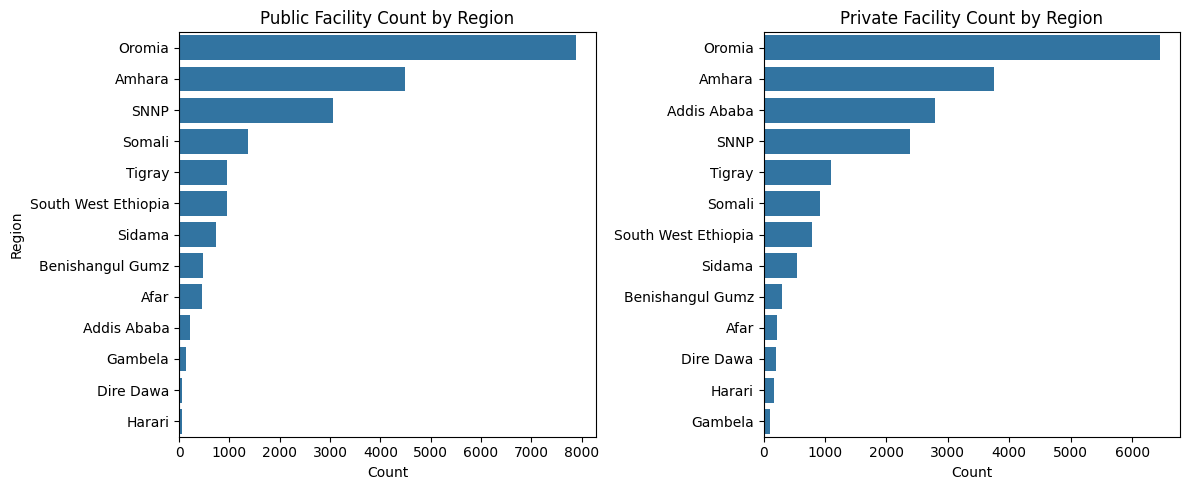

In [63]:
plt.figure(figsize=(12, 5))

# Public
plt.subplot(1, 2, 1)
sns.barplot(data=public_rank, x='facility_count', y='admin1Name')
plt.title("Public Facility Count by Region")
plt.xlabel("Count")
plt.ylabel("Region")

# Private
plt.subplot(1, 2, 2)
sns.barplot(data=private_rank, x='facility_count', y='admin1Name')
plt.title("Private Facility Count by Region")
plt.xlabel("Count")
plt.ylabel("")

plt.tight_layout()
plt.show()

    Woreda      Sub_City   City      popden        Area  \
0      W01          Yeka  Addis  159.881253  394.192424   
1      W02          Yeka  Addis  151.688325  615.367772   
2      W03          Yeka  Addis  158.575329  349.599061   
3      W04          Yeka  Addis  243.157523  107.923781   
4      W05          Yeka  Addis  144.781635  681.327350   
..     ...           ...    ...         ...         ...   
112     07  Addis ketema  Addis  130.566596   49.042897   
113     08  Addis ketema  Addis  157.492921   99.657468   
114     09  Addis ketema  Addis  109.060191   78.475861   
115     10  Addis ketema  Addis   52.491053  125.375800   
116   None          None   None   20.368886    0.000000   

                                              geometry  
0    POLYGON ((476614.201 1003543.996, 476610.74 10...  
1    POLYGON ((476614.201 1003543.996, 476765.791 1...  
2    POLYGON ((478495.517 1000222.02, 478464.537 10...  
3    POLYGON ((475594.465 998887.519, 475573.033 99...  
4    P

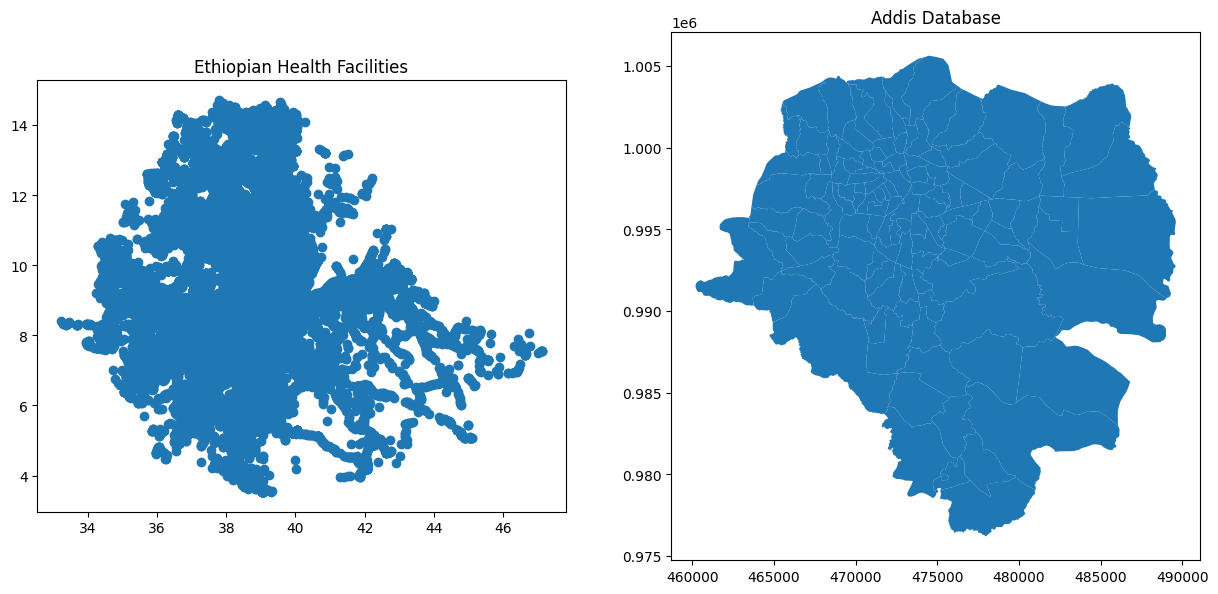

In [5]:
# Read the shapefiles
ethiopia_health = gpd.read_file('./Ethiopian_health_Facilities/Ethiopian Health Facilities.shp')
addis_db = gpd.read_file('../AddisDatabase.shp')

# Display basic information about both shapefiles
# print("Ethiopian Health Facilities Info:")
# print(ethiopia_health.info())
# print("\nAddis Database Info:")
# print(addis_db.info())

print(addis_db)

# Plot both shapefiles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ethiopia_health.plot(ax=ax1)
ax1.set_title('Ethiopian Health Facilities')
addis_db.plot(ax=ax2)
ax2.set_title('Addis Database')
plt.show()

Ethiopia Health Facilities CRS: EPSG:4326
Addis Database CRS: EPSG:20137

Total number of woredas in merged dataset: 44

Merged Dataset Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 117 entries, 0 to 116
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Woreda       116 non-null    object  
 1   Sub_City     116 non-null    object  
 2   City_left    116 non-null    object  
 3   popden       117 non-null    float64 
 4   Area         117 non-null    float64 
 5   geometry     116 non-null    geometry
 6   index_right  0 non-null      float64 
 7   Id           0 non-null      float64 
 8   Name         0 non-null      object  
 9   Latitude     0 non-null      float64 
 10  Longitude    0 non-null      float64 
 11  Altitude     0 non-null      float64 
 12  Ownership    0 non-null      object  
 13  Type         0 non-null      object  
 14  admin3Name   0 non-null      object  
 15  admin3Pcod   0

/var/folders/c0/dyr7lhs539qgknm4b18w4b180000gn/T/ipykernel_80692/2762620615.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:20137
Right CRS: EPSG:4326

  addis_health = gpd.sjoin(addis_db, ethiopia_health, how='left', predicate='intersects')


<Figure size 1200x800 with 0 Axes>

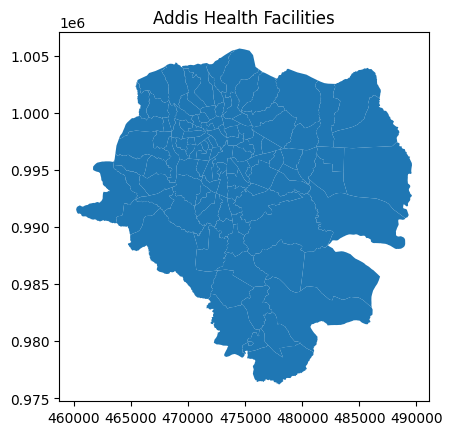

In [31]:
# Print CRS for both datasets
print("Ethiopia Health Facilities CRS:", ethiopia_health.crs)
print("Addis Database CRS:", addis_db.crs)

# Perform a spatial join (left join) of health facilities to Addis data
addis_health = gpd.sjoin(addis_db, ethiopia_health, how='left', predicate='intersects')

# Print total number of woredas in the merged dataset
print("\nTotal number of woredas in merged dataset:", len(addis_health['Woreda'].unique()))

# Display basic information about the merged dataset
print("\nMerged Dataset Info:")
print(addis_health.info())

# Plot the merged dataset
plt.figure(figsize=(12, 8))
addis_health.plot()
plt.title('Addis Health Facilities')
plt.show()
